In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel # Feature selector
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import stats, uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import *
from sklearn import feature_selection
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('Challenge_LATAM/custom_df.csv')
df.head(3)

,Unnamed: 0,DIA,MES,DIANOM,dif_min,atraso_15,temporada_alta,periodo_dia,cambio_aerolinea,cambio_num_vuelo,...,SIGLADES_Montevideo,SIGLADES_Nueva York,SIGLADES_Other,SIGLADES_Paris,SIGLADES_Puerto Montt,SIGLADES_Punta Arenas,SIGLADES_Rio de Janeiro,SIGLADES_Sao Paulo,SIGLADES_Temuco,SIGLADES_Valdivia
0,0,1,1,6,3.0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1,0,9.0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,3,1,1,9.0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def dropcol(df,cols):
        return df.drop(cols, axis = 1, inplace = True)
dropcol(df,'Unnamed: 0')

Preparamos el dataset para el modelo

In [4]:
y = df['atraso_15']
X = df.drop(['atraso_15', 'dif_min'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=20, stratify=y)
# stratify = y because it's an imbalanced dataset

#### Métrica utilizada

Para determinar cuál es el modelo que mejor performa, hemos elegido la métrica de recall. 

$$ Recall\: \frac{TP}{TP + FN } $$

El recall se centra en los True Positives - es decir, se utiliza para saber cuantos Verdaderos Positivos son correctamente clasificados por el modelo. 
En nuestro caso, es más importante que el modelo identifique como vuelos atrasados todos los vuelos que realmente se han atrasado, ya que entendemos que los FN (predecir vuelo como no atrasado cuando en realidad es atrasado) puede tener un impacto negativo en el cliente. 

También vamos a centrarnos en f1_score micro.
F1 Score es una métrica que combina el precision y el recall. 
$$ F1\ = 2 * \frac{recall * precision }{recall + precision } $$
Micro-average se prefiere cuando hay un class imbalance.

En Micro-average method:hace una media global del F1 score contando las sumas de los TP, FN y FP. 

## Modelos de Clasificación
#### 1. Random Forest
Random Forest es una metodología de bagging donde, seleccionando un subset de features, el método es capaz de capturar el impacto de las diferentes variables, llevando al modelo a tener un gran poder predictivo. 

Hay varios hiperparámetros en el modeo que tenemos que tunear, acorde a la data y ss características. 

Es importante resaltar que una de las características de los tree-based models, es que son eficientes en el manejo de variables categóricas y de data no-normalizada - creando modelos interpretables. 

Usamos class_weight = 'balanced' ya que se trata de un imbalanced dataset.

Vamos a crear a entrenar el Random Forest con la data normalizada (usando StandardScaler) y no normalizada, y comparareros ambos resultados. 

In [53]:
# Random Forest
rf_pipe_scl = Pipeline([('scl', StandardScaler()),
                ('clf', RandomForestClassifier(class_weight='balanced', random_state = 42)),
                        ])

rf_pipe =  Pipeline([
                ('clf', RandomForestClassifier(class_weight='balanced', random_state = 42)),
                        ])
                        
param_range = [3, 4, 5, 6, 7, 8, 9, 10, 11]
param_range_fl = [1.0, 0.7, 0.5, 0.3, 0.1, 0.01]


grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range}]

# Randomized Search
n_jobs = -1 #n_jobs to run faster
skf = StratifiedKFold(n_splits=10)

gs_rf_scl = RandomizedSearchCV(estimator= rf_pipe_scl, 
                           param_distributions=grid_params_rf, 
                           scoring = "recall",
                           cv= skf) 

gs_rf = RandomizedSearchCV(estimator= rf_pipe, 
                           param_distributions=grid_params_rf, 
                           scoring = "recall",
                           cv= skf) 

grids = [gs_rf_scl, gs_rf]

# Dictionary of pipelines and classifier types for reference 
grid_dict = {0: 'Random Forest with Scaling', 1: 'Random Forest'}

# Fit the grid search 
print("Training model...")

best_recall = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training recall Score
    print('Best training recall Score: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data recall of model with best params
    print('Test set recall score for best params: %.3f ' % recall_score(y_test, y_pred))
    # Track best (highest test recall) model
    if recall_score(y_test, y_pred) > best_recall:
        best_recall = recall_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
        
print('\nClassifier with best test set recall_score: %s' % grid_dict[best_clf])

print('classifiers trained!')

Training model...

Estimator: Random Forest with Scaling
Best params: {'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_depth': 7, 'clf__criterion': 'entropy'}
Best training recall Score: 0.673
Test set recall score for best params: 0.669 

Estimator: Random Forest
Best params: {'clf__min_samples_split': 8, 'clf__min_samples_leaf': 4, 'clf__max_depth': 8, 'clf__criterion': 'entropy'}
Best training recall Score: 0.674
Test set recall score for best params: 0.675 

Classifier with best test set recall_score: Random Forest
classifiers trained!


Random Forest con mejores hiperparámetros: 

In [8]:
rfc = RandomForestClassifier(class_weight='balanced',min_samples_split= 8,min_samples_leaf=4, max_depth=8, criterion='entropy', random_state=42)

rfc.fit(X, y)

y_pred = rfc.predict(X_test)
f1_score_macro = f1_score(y_test, y_pred, average='macro')
f1_score_micro = f1_score(y_test, y_pred, average='micro')

print(f'The recall is: {recall_score(y_test, y_pred)}')
print(f'The f1 micro score is: {f1_score_micro}')
print(f'The f1 macro score is: {f1_score_macro}')


The recall is: 0.6878964059196617
The f1 micro score is: 0.6195875281008699
The f1 macro score is: 0.5610564944874735


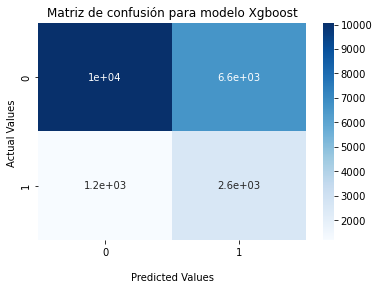

In [9]:
#Veamos la matriz de confusión
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de confusión para modelo Xgboost');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

**Completar explicación**
Random Forest Feature importance:

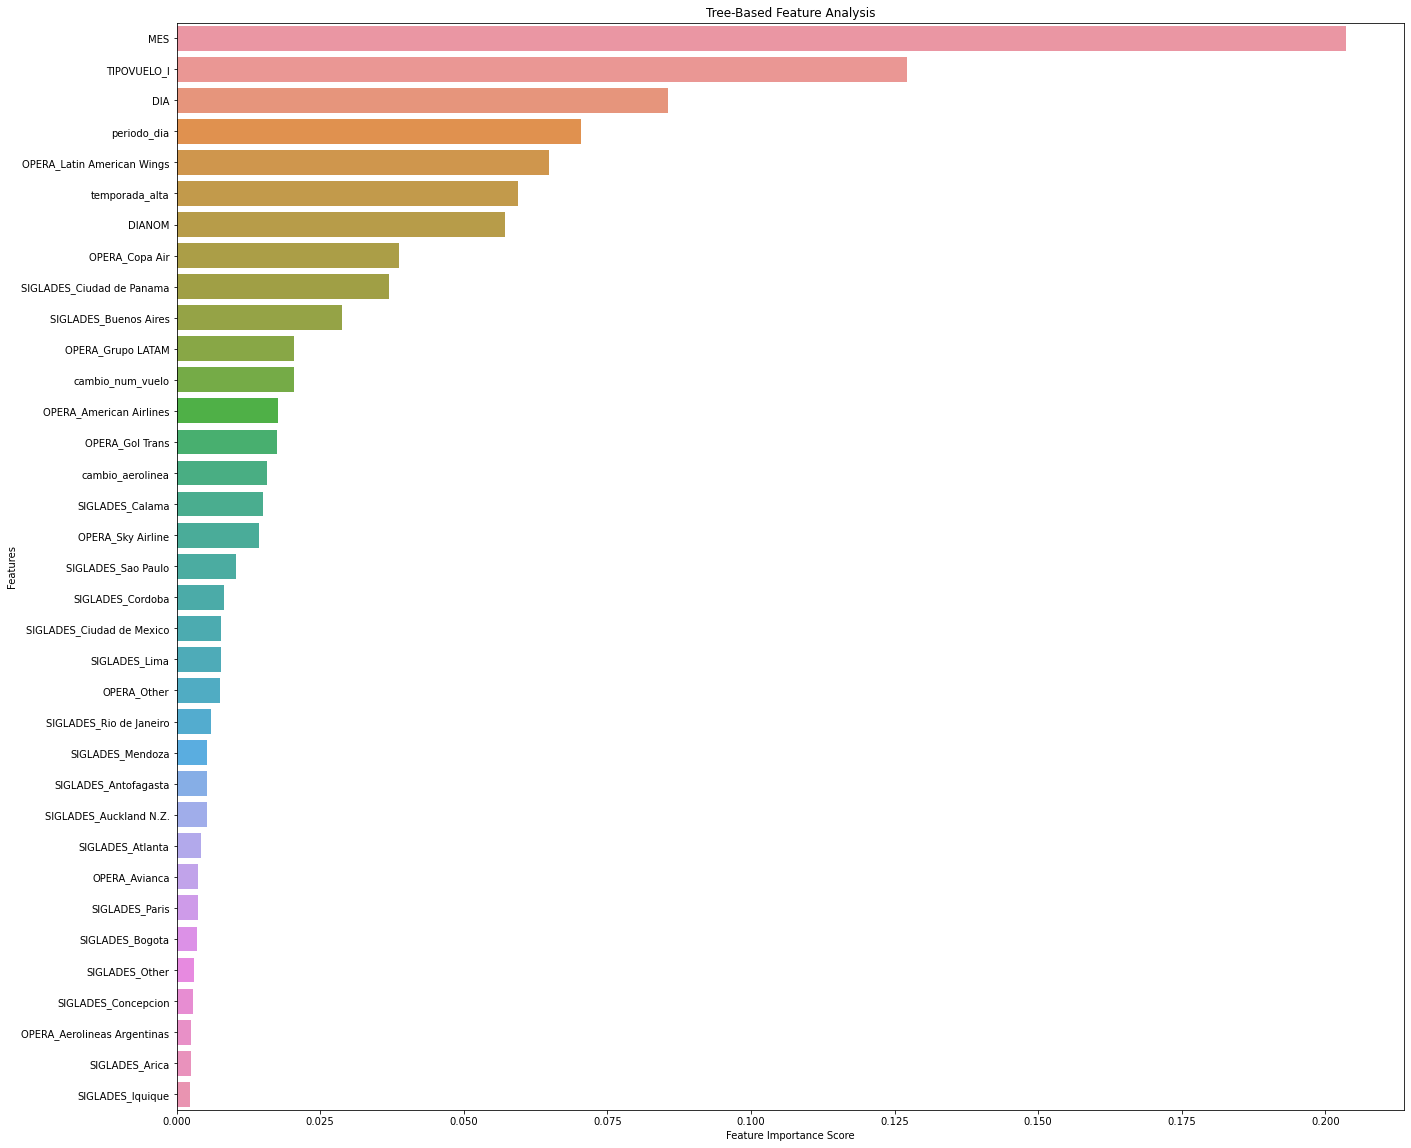

In [17]:
feature_scores = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=False).head(35)
sns.barplot(x=feature_scores, y=feature_scores.index).set_title('Tree-Based Feature Analysis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.rcParams["figure.figsize"] = (22, 20)

Las variables que más influyen en el atraso del vuelo según el modelo de Random Forest son: 
- MES del año
- TIPOVUELO_I : si el vuelo es internacional o nacional 
- DIA del mes
- periodo_dia : si el vuelo es de mañana, tarde o noche
- OPERA_Latin American Wings: si la aerolinea que opera es Latin American Wings
- temporada_alta: si el vuelo es en temporada alta
- DIANOM: el dia de la semana 
- OPERA_Copa Air: si la aerolinea que opera es Copa Air
- SIGLADES_Ciudad de Panama: si el destino del vuelo es Ciudad de Panamá
- SIGLADES_Buenos Aires: si el destino del vuelo es Buenos Aires
- OPERA_Grupo LATAM: si la aerolinea que opera es Grupo LATAM
- cambio_num_vuelo: si hubo un cambio en el numero de vuelo
- OPERA_American Airlines: si la aerolinea que opera es AA
- OPERA_Gol Trans: si la aerolinea que opera es Gol Trans
- cambio_aerolinea: si la aerolinea programada no es igual que la aerolinea que operó el vuelo. 


#### 2. Ranfom Forest Feature Selection
Vamos a incluir en el modelo las 25 variables más importantes, excluyendo las restantes. 
Con esto, estaremos metiendo menos ruido al modelo (evitando overfitting) pero a su vez quitando algunas variables que tengan influencia en el atraso de los vuelos. 

In [ ]:
main_features = feature_scores.index
y_fs = df['atraso_15']
X_fs = df[main_features]

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_fs, y_fs, test_size=0.3)

#### 3. XGBoost
Gradient boosting es una metodología ensemble en la que en cada iteración el nuevo predictor se construye para ajustarse a los pseudo-residuales del predictor anterior. El proceso de boosting tiene como objetivo reducir el bias y la varianza. 

Este modelo no puede manejar variables categóricas, con lo que una feature transformation es necesaria para incorporar variables ctegóricas al modelo. XGB no necesita otra feature transformation, como scaling o imputación de missing values. 

Vamos a definir el scale_pos_weight ya que se trata de un dataset imbalanceado. 

In [6]:
# We define scale_pos_weight (imbalanced dataset)
total_negative_examples = len(df[df['atraso_15']==0])
total_positive_examples = len(df[df['atraso_15']==1])
scale_pos_weight = total_negative_examples / total_positive_examples

In [7]:
xgb_pipe_scl = Pipeline([('scl', StandardScaler()),
                ('clf', XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 42)),
                        ])

xgb_pipe = Pipeline([
                ('clf', XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 42)),
                        ])

grid_params_xgb = [{
    'clf__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5], # Minimum loss reduction to make the split
    'clf__max_depth': [3, 5, 7, 10], # The maximum level of splits from where the model prunes backwards in terms of info. gain
    'clf__n_estimators': [100,300,500,700], # Number of boosting rounds 
    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9] # Start value - typical values are 0.5-0.9
}]

skf = StratifiedKFold(n_splits=10)
n_jobs = -1 #n_jobs to run faster

gs_xgb_scl = RandomizedSearchCV(estimator= xgb_pipe_scl, 
                           param_distributions=grid_params_xgb, 
                           scoring = "recall",
                           cv= skf, n_jobs = n_jobs) 

gs_xgb = RandomizedSearchCV(estimator= xgb_pipe, 
                           param_distributions=grid_params_xgb, 
                           scoring = "recall",
                           cv= skf, n_jobs=n_jobs) 

grids = [gs_xgb_scl, gs_xgb]

# Dictionary of pipelines and classifier types for reference 
grid_dict = {0: 'XGB with Scaling', 1: 'XGB'}

# Fit the grid search 
print("Training model...")

best_recall = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training recall Score
    print('Best training recall Score: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data recall of model with best params
    print('Test set recall score for best params: %.3f ' % recall_score(y_test, y_pred))
    # Track best (highest test recall) model
    if recall_score(y_test, y_pred) > best_recall:
        best_recall = recall_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
        
print('\nClassifier with best test set recall_score: %s' % grid_dict[best_clf])

print('classifiers trained!')

Training model...

Estimator: XGB with Scaling


KeyboardInterrupt: 

XGB con mejores hiperparámetros:

In [ ]:
xgb = XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 42)

xgb.fit(X, y)

y_pred = xgb.predict(X_test)
f1_score_macro = f1_score(y_test, y_pred, average='macro')
f1_score_micro = f1_score(y_test, y_pred, average='micro')

print(f'The recall is: {recall_score(y_test, y_pred)}')
print(f'The f1 micro score is: {f1_score_micro}')
print(f'The f1 macro score is: {f1_score_macro}')

In [ ]:
#Veamos la matriz de confusión
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de confusión para modelo Xgboost');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

#### 4. SVM - Support Vector Machine

El algoritmo SVM tiene como objetivo maximizar el "márgen máximo" de separación del hiperplano que separa las clases. En otras palabras, el objetivo del modelo es clasificar de forma efectiva los datos para que el modelo pueda generalizar mejor. 


Cuanto mayor sea la distancia entre los support vectors de los diferentes grupos, mayor será el márgen máximo de separación, y menor el error en la clasificación. Los modelos SVM tienen la opción de incluir kernels, lo que es útil cuando las clases no se pueden separar linearlmente.  

La data para SVM tiene que estar estandarizada, para poder diferenciar de manera eficiente entre las clases y aplicar correctamente las medidas de distancia.

In [6]:
svm_pipe_scl = Pipeline([('scl', StandardScaler()),
                ('clf', SVC(random_state = 42, class_weight = 'balanced')),
                        ])

param_range_fl = [1.0, 0.7, 0.5, 0.3, 0.1, 0.01]

grid_params_svm = [{
        'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
        'clf__C': param_range_fl
        }]


skf = StratifiedKFold(n_splits=10)
n_jobs = -1 #n_jobs to run faster

gs_svm_scl = RandomizedSearchCV(estimator= svm_pipe_scl, 
                           param_distributions=grid_params_svm, 
                           scoring = "recall",
                           cv= skf, n_jobs = n_jobs) 

# Fit the grid search 
print("Training model...")

gs_svm_scl.fit(X_train, y_train)

print('Best params: %s' % gs_svm_scl.best_params_)
# Best training recall Score
print('Best training recall Score: %.3f' % gs_svm_scl.best_score_)
# Predict on test data with best params
y_pred = gs_svm_scl.predict(X_test)
# Test data recall of model with best params
print('Test set recall score for best params: %.3f ' % recall_score(y_test, y_pred))

print('classifier trained!')

Training model...


#### 5. Logistic Regression

In [ ]:
logreg_pipe_scl = Pipeline([('scl', StandardScaler()),
                ('clf', LogisticRegression(random_state = 42, class_weight = 'balanced')),
                        ])

param_range_fl = [1.0, 0.7, 0.5, 0.3, 0.1, 0.01]

grid_params_logreg = [{
        'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
        'clf__C': param_range_fl
        }]


skf = StratifiedKFold(n_splits=10)
n_jobs = -1 #n_jobs to run faster

gs_logreg_scl = RandomizedSearchCV(estimator= logreg_pipe_scl, 
                           param_distributions=grid_params_logreg, 
                           scoring = "recall",
                           cv= skf, n_jobs = n_jobs) 

# Fit the grid search 
print("Training model...")

gs_logreg_scl.fit(X_train, y_train)

print('Best params: %s' % gs_logreg_scl.best_params_)
# Best training recall Score
print('Best training recall Score: %.3f' % gs_logreg_scl.best_score_)
# Predict on test data with best params
y_pred = gs_logreg_scl.predict(X_test)
# Test data recall of model with best params
print('Test set recall score for best params: %.3f ' % recall_score(y_test, y_pred))

print('classifiers trained!')